#  Converting between global and local axis systems

IN: MDCM charges, atom positions (from cube file), reference frames   
OUT: MDCM charges shifted to reflect the new local axis system

## 1. Load initial variables
Note: in this code, atoms are 0 indexed
For the MDCM module in CHARMM the atoms are labelled from 1

In [12]:
import numpy as np
import os, sys
from scipy.spatial import distance
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib ipympl

home_path = "/home/boittier/Documents/AdjustReference-System/"
#home_path = "/home/eric/Documents/PhD/AdjustReference-System/"

sys.path.insert(1, home_path)
from Cube import read_charges_refined, read_cube


BOHR_TO_ANGSTROM = 0.529177

#  Define Variables

# # F-butadiene example
# folder = "fbuta/pos1/"
# xyz_file_name = home_path + folder + "36_charges_refined.xyz"
# pcube = home_path + folder + "B.p.cube"0.529177
# frame_file = home_path + folder + "frames.txt"

# Water Example
folder = "water/"

xyz_file_name = home_path + folder + "8_charges_refined.xyz"
pcube = home_path + folder + "Water_5_5_4.pot.cube"
frame_file = home_path + folder + "frames.txt"

# Open XYZ file
xyz_file = open(xyz_file_name).readlines()
#  read number of charges from first line (xyz format)
n_charges = int(xyz_file[0])
charge_lines = xyz_file[2:n_charges+2]
# Read atoms and charges
c_positions = []
c_charges = []
for charge in charge_lines:
    on, x, y, z, c = charge.split()
    c_positions.append([float(x), float(y) , float(z)])
    c_charges.append(float(c))
    
# Open Cube file
pcube_data, pcube_meta = read_cube(pcube)
atom_positions = []
atom_names = []
for i in pcube_meta["atoms"]:
    atom = list(i[1])
    atom_positions.append([x *BOHR_TO_ANGSTROM for x in atom[1:]])

    atom_names.append(atom[1])
n_atoms = len(atom_names)

# Match each charge to a nucleus
charge_atom_associations = []
atom_charge_dict = {}
for i_charge in range(n_charges):
    min_distance = np.Inf #  initial distance, which can be compared to find smaller values
    for j_atom in range(n_atoms):       
        d = distance.euclidean(c_positions[i_charge], atom_positions[j_atom])
        if d < min_distance:
            atom_association = j_atom
            min_distance = d
    charge_atom_associations.append([i_charge, atom_association])
    
    if atom_association not in list(atom_charge_dict.keys()):
        atom_charge_dict[atom_association] = [i_charge]
    else:
        atom_charge_dict[atom_association].append(i_charge)

    
# Get frames
frame = open(frame_file).readlines()
frame_atoms = []
frames = frame[1:]
n_frames = len(frames)
for f in frames:
    a1, a2, a3 = f.split()
    frame_atoms.append([int(a1), int(a2), int(a3)])


In [13]:
def get_local_axis(atom_pos, frame_atoms):
    """
    Inputs:
                atom_positions, frames
    Returns: 
                List of Lists of Frame Vectors [ [x_v, y_v, z_v], ...  ] in order of frames
    """
    n_frames = len(frame_atoms)
    frame_vectors = []
    for f in range(n_frames):
        a_index , b_index, c_index = frame_atoms[f]
        a,b,c = frame_atoms[f]
        a = atom_pos[a-1]
        b = atom_pos[b-1]
        c = atom_pos[c-1]
        """
        Find the position of A and B (and normalise by the distance) to get the local axes
        """
        distance_ab = distance.euclidean(a, b)
        bond1_x = (a[0] - b[0])/distance_ab
        bond1_y = (a[1] - b[1])/distance_ab
        bond1_z = (a[2] - b[2])/distance_ab
        z_local_vector = [bond1_x, bond1_y, bond1_z]
        """
        Find the position of B and C (and normalise by the distance) to get the local axes
        """
        distance_bc = distance.euclidean(b, c)
        bond2_x = (b[0] - c[0])/distance_bc
        bond2_y = (b[1] - c[1])/distance_bc
        bond2_z = (b[2] - c[2])/distance_bc
        y_local_vector = [bond2_x, bond2_y, bond2_z]
        """
        X-axes (should be the cross product)
        """
        x_local_vector = np.cross(z_local_vector, y_local_vector)
        
        frame_vectors.append([x_local_vector, y_local_vector, z_local_vector])
    return frame_vectors

atom_charge_dict

{0: [0, 1, 2], 1: [3, 4], 2: [5, 6, 7]}

## 2. Calculate the transformation

Each charge in associated with an atom.
Atoms are used to define local reference axes.

Global = x, y, z  
Local = p, q, r

Find a transformation from (xyz) -> (pqr)  


find pqr in terms of xyz
p = || A - B ||
q = || B - C ||
r (i.e. z) is the cross product = ||A|| ||B|| sin(theta)

Normalise between (0, 1) by dividing the distance from atom a to b



In [33]:
# Calculate local axes and transform charges

# Calculate the new axes for each frame
frame_vectors = get_local_axis(atom_positions, frame_atoms)


"""
Global ==> Local
"""
#  Find the position of the charges in the local axes
#  Create a new array for the 'local' charges
c_pos_shape = np.array(c_positions).shape
c_positions_local = np.zeros(c_pos_shape)
used_atoms = []
for f in range(n_frames):
    #print(f"Frame: {frame_atoms[f]}")
    x_local_vector, y_local_vector, z_local_vector = frame_vectors[f]

    #  Loop through the atoms in the frame
    for atom_index in frame_atoms[f]:
        #  adjust indexing
        atom_index = atom_index - 1
        if atom_index in list(atom_charge_dict.keys()) and atom_index not in used_atoms:
            charges = atom_charge_dict[atom_index]

            #  Find the associated charges for that atom, and loop
            for charge in charges:
                c_pos_global = c_positions[charge]
                atom_pos_xyz = atom_positions[atom_index]
                # 
                dx = c_pos_global[0] - atom_pos_xyz[0]
                dy = c_pos_global[1] - atom_pos_xyz[1]
                dz = c_pos_global[2] - atom_pos_xyz[2]
                
                pos = np.dot(glob_to_local, np.array([dx,dy,dz]))
                
                print( pos )
                
                local_x_pos =  np.multiply(x_local_vector, dx)
                local_y_pos =  np.multiply(y_local_vector, dy)
                local_z_pos =  np.multiply(z_local_vector, dz)
                
                print(local_x_pos.sum(), local_y_pos.sum(), local_z_pos.sum() )
                print()
                c_positions_local[charge][0] = local_x_pos.sum()
                c_positions_local[charge][1] =  local_y_pos.sum()
                c_positions_local[charge][2] = local_z_pos.sum()
                
        used_atoms.append(atom_index)





[ 1.59288406e-06 -5.47753815e-02 -3.98529769e-01]
1.5928840618367454e-06 -0.4076408722159599 0.04336550046216106

[ 8.46984193e-06 -3.86536747e-02 -1.21842564e-01]
8.469841930690035e-06 -0.14432844320038196 0.010494492424226544

[ 1.02484780e-06 -5.89683653e-02  5.91402739e-02]
1.0248478006966222e-06 0.00015459114473995644 -0.014899708716646955

[ 4.14815711e-06 -1.46228605e-01  1.46411216e-01]
4.148157113156898e-06 0.00016421555131226786 -0.036917266325605214

[ 5.37665193e-05 -1.54592799e-01  1.54782228e-01]
5.3766519295676155e-05 0.00017034652058861105 -0.03902845558998164

[ 1.25303846e-05  2.36728746e-02 -3.37250893e-01]
1.253038456336904e-05 -0.28198933260380743 0.04553146190581783

[6.24750015e-06 3.75007116e-02 1.74064976e-02]
6.247500148370165e-06 0.04937606074979895 0.0025349367973090276

[-1.19832923e-05  6.48350018e-02 -3.69048475e-01]
-1.198329232324185e-05 -0.2735681372585687 0.05473551697547607



In [34]:
x_local_vector

array([ 0.97521369, -0.        ,  0.        ])

In [35]:
y_local_vector

[0.0, 0.7814298191408283, 0.6239931391910749]

In [36]:
z_local_vector

[0.0, 0.7814298191408283, -0.6239931391910749]

In [37]:


glob_to_local = np.array([x_local_vector,y_local_vector,z_local_vector])
glob_to_local

array([[ 0.97521369, -0.        ,  0.        ],
       [ 0.        ,  0.78142982,  0.62399314],
       [ 0.        ,  0.78142982, -0.62399314]])

In [38]:
from scipy import linalg
linalg.inv(glob_to_local)


array([[ 1.02541628,  0.        ,  0.        ],
       [ 0.        ,  0.63985273,  0.63985273],
       [ 0.        ,  0.80129086, -0.80129086]])

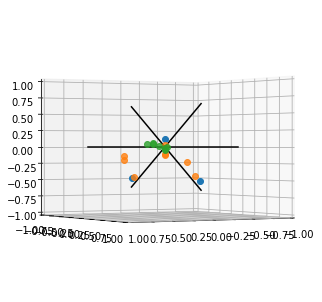

In [39]:
def plot_axe(x_local_vector, y_local_vector, z_local_vector, c="k"):
    x = [-x_local_vector[0], 0, x_local_vector[0]]
    y = [-x_local_vector[1], 0, x_local_vector[1]]
    z = [-x_local_vector[2], 0, x_local_vector[2]]
    plt.plot(x, y, z, c=c)
    x = [-y_local_vector[0], 0, y_local_vector[0]]
    y = [-y_local_vector[1], 0, y_local_vector[1]]
    z = [-y_local_vector[2], 0, y_local_vector[2]]
    plt.plot(x, y, z, c=c)
    x = [-z_local_vector[0], 0, z_local_vector[0]]
    y = [-z_local_vector[1], 0, z_local_vector[1]]
    z = [-z_local_vector[2], 0, z_local_vector[2]]
    plt.plot(x, y, z, c=c)

fig = plt.figure()
ax = Axes3D(fig, elev=0, azim=60)
# Transpose to the right shape for plotting
a_p = np.array(atom_positions).T
#a_p1 = np.array(atom_positions_plus).T
c_p = np.array(c_positions).T
c_p_l = np.array(c_positions_local).T
# Plotting
plot_axe(x_local_vector, y_local_vector, z_local_vector)
#plot_axe(*frame_vectors_plus[0], c="b")
plt.plot(a_p[0], a_p[1], a_p[2], linestyle = 'None',  marker="o")
#plt.plot(a_p1[0], a_p1[1], a_p1[2], marker="o")
plt.plot(c_p[0], c_p[1], c_p[2], marker="o", linestyle = 'None', alpha=0.8)
plt.plot(c_p_l[0], c_p_l[1], c_p_l[2], marker="o", linestyle = 'None', alpha=0.8)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
    
plt.show()

In [6]:
atom_positions = np.array(atom_positions)
#  Random pertubation of atom positions to simulate a new conformation
atom_positions_plus = atom_positions + [[1,1.5,1], [1,0,1], [2,2,2]]
#  Find the new axes for this conformation
frame_vectors_plus = get_local_axis(atom_positions_plus, frame_atoms)

"""
Local ==> Global
"""
#  Find the position of the charges in the local axes
#  Create a new array for the 'local' charges
c_pos_shape = np.array(c_positions).shape

c_new_local = np.zeros(c_pos_shape)
c_positions_global = np.zeros(c_pos_shape)
used_atoms = []

for f in range(n_frames):
    x_local_vector, y_local_vector, z_local_vector = frame_vectors[f]
    x_local_vector_p, y_local_vector_p, z_local_vector_p = frame_vectors_plus[f]
    
    #  Loop through the atoms in the frame
    for atom_index in frame_atoms[f]:
        #  adjust indexing
        atom_index = atom_index - 1
        if atom_index in list(atom_charge_dict.keys()) and atom_index not in used_atoms:
            charges = atom_charge_dict[atom_index]
            
            #  Find the associated charges for that atom, and loop
            for charge in charges:
                c_pos_local = c_positions_local[charge]
                
                atom_pos_xyz_p = atom_positions_plus[atom_index]

#                 dx = c_pos_local[0] - atom_pos_xyz_p[0]
#                 dy = c_pos_local[1] - atom_pos_xyz_p[1]
#                 dz = c_pos_local[2] - atom_pos_xyz_p[2]
                
                local_x_pos =  np.multiply(x_local_vector_p, c_pos_local[0])
                local_y_pos =  np.multiply(y_local_vector_p, c_pos_local[1])
                local_z_pos =  np.multiply(z_local_vector_p, c_pos_local[2])
                                
                c_new_local[charge][0] = local_x_pos.sum()
                c_new_local[charge][1] = local_y_pos.sum()
                c_new_local[charge][2] = local_z_pos.sum()
                
#                 c_positions_global[charge][0] = global_x_pos.sum()
#                 c_positions_global[charge][1] = global_y_pos.sum()
#                 c_positions_global[charge][2] = global_z_pos.sum()
                
                
                
        used_atoms.append(atom_index)


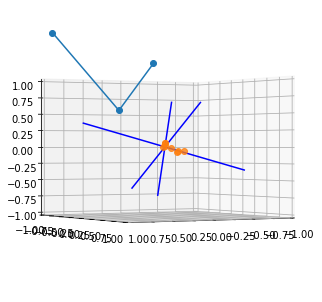

In [11]:
fig = plt.figure()
ax = Axes3D(fig, elev=0, azim=60)

# Transpose to the right shape for plotting
a_p = np.array(atom_positions).T
a_p1 = np.array(atom_positions_plus).T
c_p = np.array(c_positions).T
c_p_l = np.array(c_positions_local).T
c_p_g = np.array(c_new_local).T

# Plotting
#plot_axe(x_local_vector, y_local_vector, z_local_vector)
plot_axe(*frame_vectors_plus[0], c="b")
#plt.plot(a_p[0], a_p[1], a_p[2], marker="o")
plt.plot(a_p1[0], a_p1[1], a_p1[2], marker="o")
#plt.plot(c_p[0], c_p[1], c_p[2], marker="o", linestyle = 'None', alpha=0.8)
plt.plot(c_p_g[0], c_p_g[1], c_p_g[2], marker="o", linestyle = 'None', alpha=0.8)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_zlim(-2,2)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
plt.show()

In [8]:
c_positions_global

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])